In [11]:
# Impor library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random

# Sastrawi & Stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Scikit-learn, Scikit-multilearn & Imbalanced-learn
from skmultilearn.model_selection import iterative_train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# Mengatur environment
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

In [12]:
# @title 2. Memuat & Preprocessing Data
df = pd.read_csv('dataset_berita_multilabel2.csv')
df_sw = pd.read_csv('stopwordbahasa.csv', header=None)

# Fungsi-fungsi preprocessing
def text_lower(text): return text.lower()
def normalize_and_clean_text(text):
    text = re.sub(r'<.*?>', ' ', text); text = re.sub(r'[^a-zA-Z\s]', ' ', text); text = re.sub(r'\s+', ' ', text)
    return text.strip()

stopword_factory = StopWordRemoverFactory()
sastrawi_stopwords = set(stopword_factory.get_stop_words())
custom_stopwords = set(df_sw[0])
all_stopwords = sastrawi_stopwords.union(custom_stopwords)

def remove_stopwords(text, stopwords_set):
    words = text.split()
    return " ".join([word for word in words if word not in stopwords_set])

print("Memulai proses preprocessing teks...")
df['cleaned_konten'] = df['konten'].astype(str).progress_apply(text_lower)
df['cleaned_konten'] = df['cleaned_konten'].progress_apply(normalize_and_clean_text)
df['cleaned_konten'] = df['cleaned_konten'].progress_apply(lambda x: remove_stopwords(x, all_stopwords))
print("Preprocessing teks selesai.")

# --- Menyiapkan Fitur (X) dan Label (Y) untuk Multilabel ---
labels = ['hukum', 'politik', 'ekonomi']
X = df['cleaned_konten'].values
y = df[labels].values

print(f"\nBentuk data fitur (X): {X.shape}")
print(f"Bentuk data label (y): {y.shape}")

Memulai proses preprocessing teks...


100%|██████████| 968/968 [00:00<00:00, 404149.54it/s]

Preprocessing teks selesai.

Bentuk data fitur (X): (968,)
Bentuk data label (y): (968, 3)


In [13]:
# @title 3. Pembagian Data (Iterative Stratified Split untuk Multilabel)
# Menggunakan iterative_train_test_split untuk menjaga proporsi kombinasi label
print("Membagi data menjadi data latih dan uji (80:20) menggunakan iterative split...")
X_train, y_train, X_test, y_test = iterative_train_test_split(X.reshape(-1, 1), y, test_size=0.2)

# Mengembalikan X_train dan X_test ke bentuk 1D array
X_train = X_train.ravel()
X_test = X_test.ravel()

print(f"\nJumlah data latih awal: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")
print("\nDistribusi label pada data latih (sebelum oversampling):")
print(pd.DataFrame(y_train, columns=labels).sum())

Membagi data menjadi data latih dan uji (80:20) menggunakan iterative split...

Jumlah data latih awal: 774
Jumlah data uji: 194

Distribusi label pada data latih (sebelum oversampling):
hukum      200
politik    463
ekonomi    167
dtype: int64


In [14]:
# @title 5. Tokenisasi dan Padding
VOCAB_SIZE = 5000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [15]:
# @title 6. Membangun dan Melatih Model BiLSTM Multilabel
# Arsitektur model untuk multilabel
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(len(labels), activation='sigmoid') # 3 neuron output dengan aktivasi sigmoid
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Loss function untuk multilabel
    metrics=['accuracy']
)

model.summary()

# Melatih model
print("\nMelatih model BiLSTM Multilabel...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    X_train_pad,
    y_train, # Targetnya adalah matriks biner (multi-hot)
    epochs=100,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          640000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 200, 128)          98816     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 200, 128)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                

7/7 [==============================] - 0s 17ms/step
--- Laporan Evaluasi Model Multilabel ---
🎯 Subset Accuracy (Kecocokan Penuh): 0.6907
🔻 Hamming Loss (Rata-rata Kesalahan per Label): 0.1168

--- Skor ROC-AUC (Per Label & Rata-rata) ---
📈 ROC-AUC (Macro Average): 0.9245
📈 ROC-AUC (Weighted Average): 0.9278

Skor ROC-AUC per Label:
   - Hukum     : 0.9321
   - Politik   : 0.9329
   - Ekonomi   : 0.9085

--- Laporan Klasifikasi (Per Label Individu) ---
              precision    recall  f1-score   support

       hukum       0.87      0.82      0.85        50
     politik       0.92      0.84      0.87       116
     ekonomi       0.87      0.48      0.62        42

   micro avg       0.90      0.76      0.82       208
   macro avg       0.89      0.71      0.78       208
weighted avg       0.90      0.76      0.81       208
 samples avg       0.63      0.60      0.61       208


--- Confusion Matrix (Per Label Individu) ---


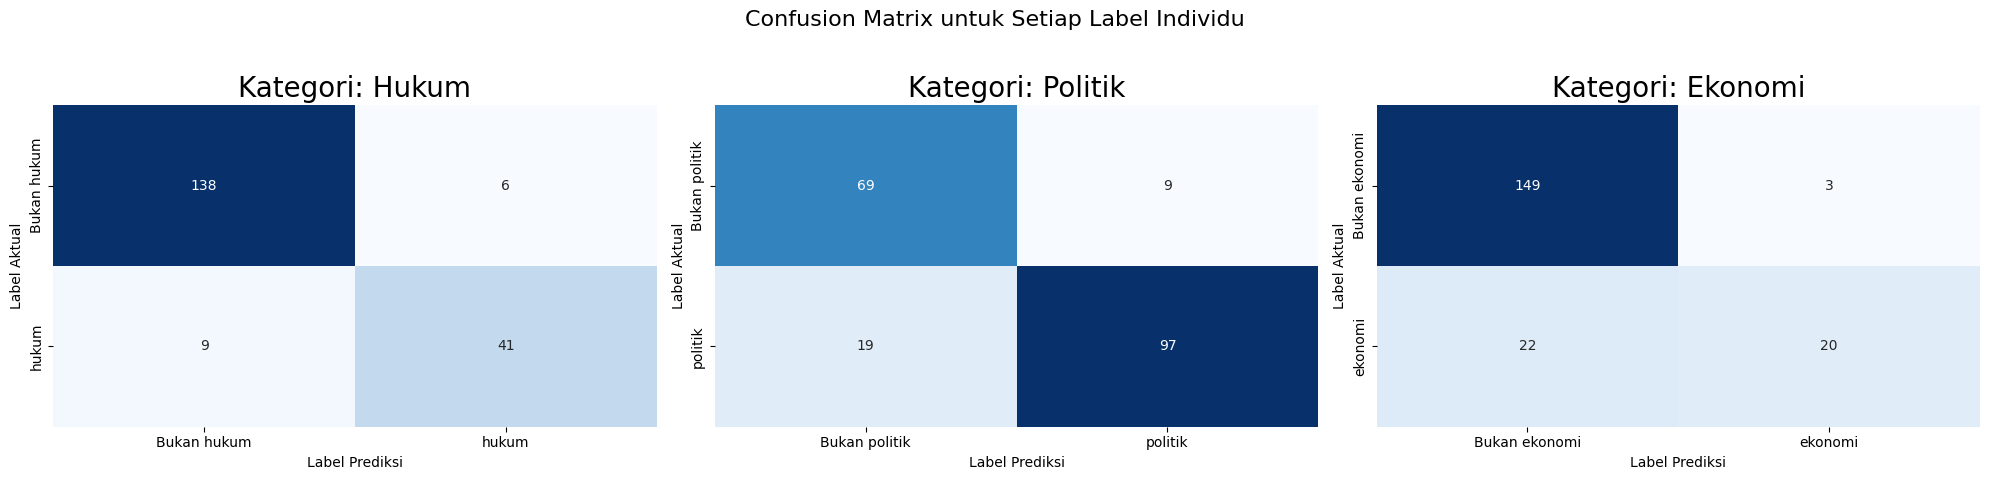



--- Laporan Evaluasi Berdasarkan 7 Kombinasi Label (Format Tabel) ---


,precision,recall,f1-score,support
ekonomi,1.00,0.46,0.63,13.00
ekonomi-politik,0.83,0.56,0.67,18.00
hukum,0.52,0.57,0.55,21.00
hukum-ekonomi,0.00,0.00,0.00,4.00
hukum-politik,0.68,0.72,0.70,18.00
hukum-politik-ekonomi,1.00,0.57,0.73,7.00
lainnya,0.53,0.78,0.63,40.00
politik,0.82,0.79,0.81,73.00
accuracy,0.69,0.69,0.69,0.69
macro avg,0.67,0.56,0.59,194.00



📈 Confusion Matrix (Berdasarkan 7 Kombinasi Label):


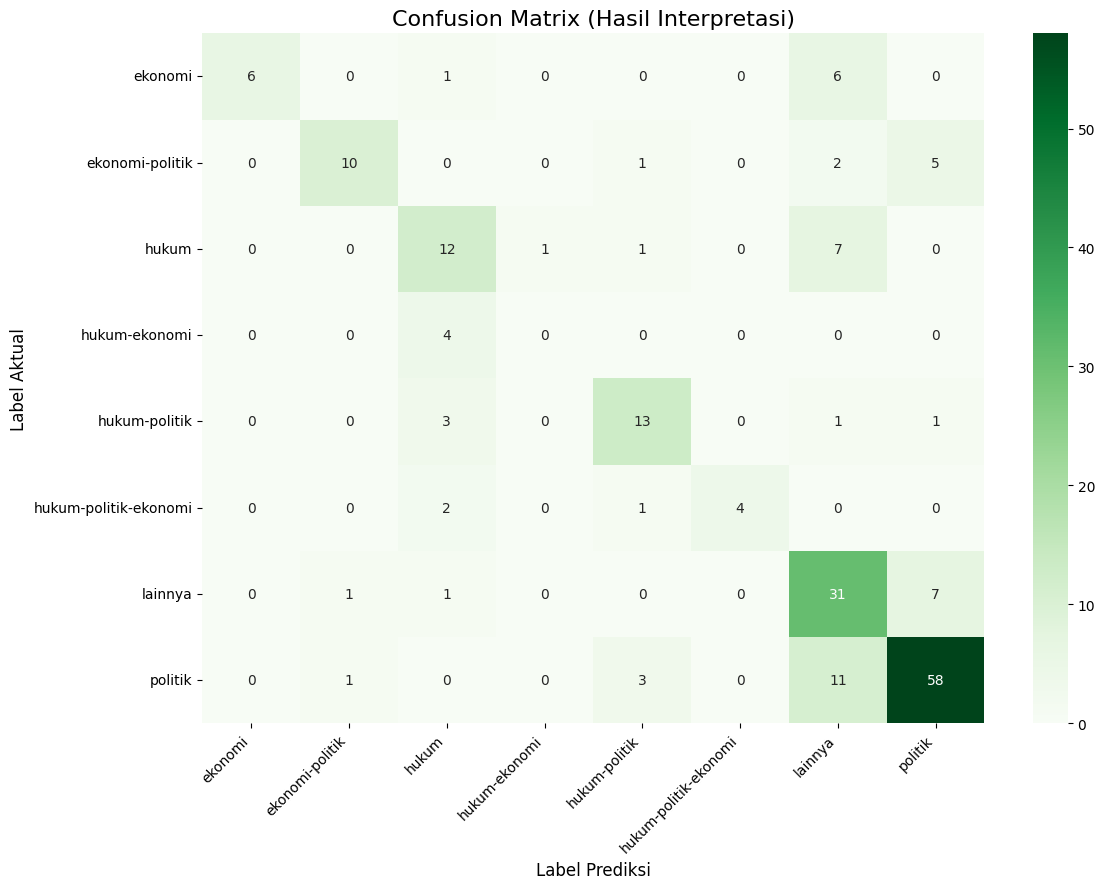

In [16]:
# @title 7. Evaluasi Model (Laporan Lengkap dengan Semua Confusion Matrix)

from sklearn.metrics import roc_auc_score, accuracy_score, hamming_loss, classification_report, confusion_matrix, multilabel_confusion_matrix
import pandas as pd

# Langkah 1 & 2: Prediksi dan konversi ke biner
y_pred_proba = model.predict(X_test_pad)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# --- Evaluasi Metrik Multilabel Standar ---
print("--- Laporan Evaluasi Model Multilabel ---")
subset_accuracy = accuracy_score(y_test, y_pred_binary)
print(f"🎯 Subset Accuracy (Kecocokan Penuh): {subset_accuracy:.4f}")

hamming = hamming_loss(y_test, y_pred_binary)
print(f"🔻 Hamming Loss (Rata-rata Kesalahan per Label): {hamming:.4f}")

# --- Skor ROC-AUC ---
print("\n--- Skor ROC-AUC (Per Label & Rata-rata) ---")
try:
    roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')
    roc_auc_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted')
    print(f"📈 ROC-AUC (Macro Average): {roc_auc_macro:.4f}")
    print(f"📈 ROC-AUC (Weighted Average): {roc_auc_weighted:.4f}\n")
    print("Skor ROC-AUC per Label:")
    for i, label in enumerate(labels):
        roc_label = roc_auc_score(y_test[:, i], y_pred_proba[:, i])
        print(f"   - {label.capitalize():<10}: {roc_label:.4f}")
except ValueError:
    print("Tidak dapat menghitung ROC-AUC.")

# --- Laporan Klasifikasi per Label ---
print("\n--- Laporan Klasifikasi (Per Label Individu) ---")
print(classification_report(y_test, y_pred_binary, target_names=labels, zero_division=0))


# --- KODE BARU UNTUK CONFUSION MATRIX PER LABEL INDIVIDU ---
print("\n--- Confusion Matrix (Per Label Individu) ---")
cm_per_label = multilabel_confusion_matrix(y_test, y_pred_binary)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Confusion Matrix untuk Setiap Label Individu', fontsize=16)

for i, (matrix, label) in enumerate(zip(cm_per_label, labels)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=[f'Bukan {label}', label],
                yticklabels=[f'Bukan {label}', label])
    axes[i].set_title(f'Kategori: {label.capitalize()}', fontsize=20)
    axes[i].set_ylabel('Label Aktual')
    axes[i].set_xlabel('Label Prediksi')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# --- AKHIR DARI KODE BARU ---


# --- Interpretasi menjadi 7 Kombinasi untuk Laporan Tabel ---
def interpret_binary_to_string_label(binary_predictions):
    label_map = {
        (1, 0, 0): "hukum", (0, 0, 1): "ekonomi", (0, 1, 0): "politik",
        (1, 0, 1): "hukum-ekonomi", (1, 1, 0): "hukum-politik",
        (0, 1, 1): "ekonomi-politik", (1, 1, 1): "hukum-politik-ekonomi",
        (0, 0, 0): "lainnya"
    }
    final_labels = [label_map.get(tuple(pred), "lainnya") for pred in binary_predictions]
    return np.array(final_labels)

# (Sisa kode untuk laporan kombinasi dan confusion matrix kombinasi tidak perlu diubah)
y_pred_combination = interpret_binary_to_string_label(y_pred_binary)
y_true_combination = interpret_binary_to_string_label(y_test)
all_possible_classes = sorted(list(set(y_true_combination) | set(y_pred_combination)))

print("\n\n--- Laporan Evaluasi Berdasarkan 7 Kombinasi Label (Format Tabel) ---")
report_dict = classification_report(y_true_combination, y_pred_combination, labels=all_possible_classes, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df.round(2))

print("\n📈 Confusion Matrix (Berdasarkan 7 Kombinasi Label):")
cm_combination = confusion_matrix(y_true_combination, y_pred_combination, labels=all_possible_classes)
plt.figure(figsize=(12, 9))
sns.heatmap(cm_combination, annot=True, fmt='d', cmap='Greens',
            xticklabels=all_possible_classes, yticklabels=all_possible_classes)
plt.title('Confusion Matrix (Hasil Interpretasi)', fontsize=16)
plt.ylabel('Label Aktual', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# @title 8. Menyimpan Model dan Komponen untuk Deployment (Perbaikan)

import pickle

# --- Menyimpan Komponen-Komponen Penting ---

# 1. Simpan Model Keras yang sudah dilatih
model.save("bilstm_model.keras")
print("Model telah disimpan sebagai 'bilstm_model.keras'")

# 2. Simpan Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer telah disimpan sebagai 'tokenizer.pickle'")
    
# 3. Simpan daftar stopwords
with open('stopwords.pickle', 'wb') as handle:
    pickle.dump(all_stopwords, handle)
print("Daftar stopwords telah disimpan sebagai 'stopwords.pickle'")

# 4. Simpan variabel MAX_LEN
with open('max_len.pickle', 'wb') as handle:
    pickle.dump(MAX_LEN, handle)
print(f"MAX_LEN ({MAX_LEN}) telah disimpan sebagai 'max_len.pickle'")

print("\nSemua komponen yang diperlukan telah disimpan!")

Model telah disimpan sebagai 'bilstm_model.keras'
Tokenizer telah disimpan sebagai 'tokenizer.pickle'
Daftar stopwords telah disimpan sebagai 'stopwords.pickle'
MAX_LEN (200) telah disimpan sebagai 'max_len.pickle'

Semua komponen yang diperlukan telah disimpan!


In [18]:
import pandas as pd
import numpy as np
from collections import Counter

# Konversi array label jadi string kombinasi, misalnya "1-0-1"
label_str = ['-'.join(map(str, row)) for row in y_train]

# Hitung frekuensi masing-masing kombinasi
kombinasi_counts = pd.Series(label_str).value_counts()

# Tampilkan 5 kombinasi label terbanyak
print("Kombinasi label terbanyak:")
print(kombinasi_counts)

Kombinasi label terbanyak:
0-1-0    295
0-0-0    154
1-0-0     91
0-1-1     67
1-1-0     67
0-0-1     58
1-1-1     34
1-0-1      8
Name: count, dtype: int64


In [19]:
print("Jumlah kombinasi label unik:", kombinasi_counts.shape[0])

Jumlah kombinasi label unik: 8
